2025-03-25 14:05:17.697524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 14:05:17.839286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742891717.932719   21516 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742891717.960962   21516 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 14:05:18.140620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

✅ CIS Bar Chart saved successfully at: /home/srivatsa/Multiple_Crop_Disease_Detection/reports/CIS Eval Report/CIS_BarChart.png


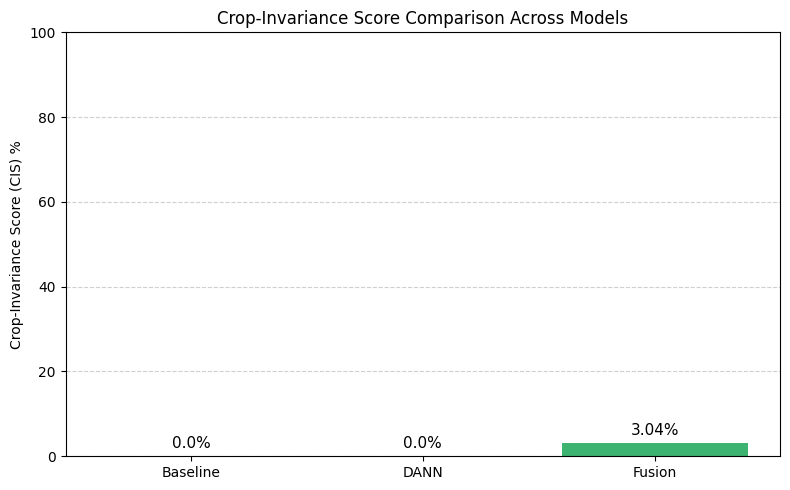

In [ ]:
# STEP 1: Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.saving import register_keras_serializable

# STEP 2: Define GradientReversal for Fusion Model
@register_keras_serializable()
class GradientReversal(tf.keras.layers.Layer):
    def __init__(self, **kwargs):  # Accept Keras-standard kwargs
        super().__init__(**kwargs)

    def call(self, x):
        @tf.custom_gradient
        def reverse_gradient(x):
            def grad(dy):
                return -dy
            return x, grad
        return reverse_gradient(x)

    def get_config(self):
        config = super().get_config()
        return config

# STEP 3: Paths
TFRECORD_PATH = "/home/srivatsa/Multiple_Crop_Disease_Detection/Dataset/PlantVillage_Structured/AUG_TFRecord/split/test.tfrecord"
ENCODER_PATHS = {
    "Baseline": "/home/srivatsa/Multiple_Crop_Disease_Detection/Models/Base_Line_Model/baseline_model_split.keras",
    "DANN": "/home/srivatsa/Multiple_Crop_Disease_Detection/Models/DANN/dann_model.keras",
    "Fusion": "/home/srivatsa/Multiple_Crop_Disease_Detection/Models/simCLR_DANN_Fusion/best_fusion_model/best_simCLR_DANN_fusionModel.keras"
}
SAVE_PATH = "/home/srivatsa/Multiple_Crop_Disease_Detection/reports/CIS Eval Report/CIS_BarChart.png"

# STEP 4: Load Dataset (Image + Crop only)
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "crop": tf.io.FixedLenFeature([], tf.int64)
}

def parse_image_crop(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    return image, example["crop"]

dataset = tf.data.TFRecordDataset(TFRECORD_PATH)
dataset = dataset.map(parse_image_crop).batch(32).prefetch(tf.data.AUTOTUNE)

# STEP 5: Function to Load Encoder up to Feature Layer
def get_encoder(model_path, model_name):
    custom_objects = {'GradientReversal': GradientReversal}
    model = tf.keras.models.load_model(model_path, compile=False, custom_objects=custom_objects)
    if model_name == "Baseline" or model_name == "DANN":
        # Extract shared dropout layer output
        encoder = tf.keras.Model(inputs=model.input, outputs=model.get_layer("dropout").output)
    else:
        # For Fusion model, we directly use pretrained encoder (no multi-task heads)
        encoder = model
    return encoder

# STEP 6: Compute CIS
cis_results = {}

for model_name, path in ENCODER_PATHS.items():
    encoder = get_encoder(path, model_name)
    all_embeddings, all_crop_labels = [], []

    for images, crop_labels in dataset:
        features = encoder(images, training=False)
        if isinstance(features, list):  # Safety: if output is list
            features = features[0]
        all_embeddings.append(features.numpy())
        all_crop_labels.append(crop_labels.numpy())

    X = np.vstack(all_embeddings)
    y = np.concatenate(all_crop_labels)

    clf = LogisticRegression(max_iter=3000, multi_class='multinomial')
    clf.fit(X, y)
    y_pred = clf.predict(X)

    cls = accuracy_score(y, y_pred) * 100
    cis = 100 - cls  # Inverted score = Crop-Invariance Score
    cis_results[model_name] = round(cis, 2)

# STEP 7: Plot and Save CIS Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(cis_results.keys(), cis_results.values(), color=["#6a5acd", "#6495ed", "#3cb371"])
plt.ylabel("Crop-Invariance Score (CIS) %")
plt.title("Crop-Invariance Score Comparison Across Models")
plt.ylim(0, 100)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f"{yval}%", ha='center', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save to file
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
plt.savefig(SAVE_PATH, dpi=300)
print(f"✅ CIS Bar Chart saved successfully at: {SAVE_PATH}")
plt.show()
